<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/Auto_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [5]:
def model_performance(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape = MAPE(y_true, y_pred)
  return f"RMSE: {rmse}, MAPE: {mape}"

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', index_col=['date'], parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', index_col=['date'], parse_dates = ['date'])

In [8]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [9]:
train = train[['country_code', 'new_confirmed']]
test = test[['country_code', 'new_confirmed']]

In [10]:
# group by countries
train_country = train.groupby(['country_code','date'])
test_country = test.groupby(['country_code','date'])
train_country_agg = train_country.agg('sum')
train_country_agg.reset_index(level = 'country_code', inplace = True)
test_country_agg = test_country.agg('sum')
test_country_agg.reset_index(level = 'country_code', inplace = True)

In [11]:
# use US as a representative
train_us = train_country_agg.loc[train_country_agg.country_code == 'US','new_confirmed']
test_us = test_country_agg.loc[test_country_agg.country_code == 'US','new_confirmed']

In [12]:
train_us

date
2020-03-01        17.0
2020-03-02        47.0
2020-03-03        56.0
2020-03-04        75.0
2020-03-05        75.0
                ...   
2021-12-27    535815.0
2021-12-28    380733.0
2021-12-29    489474.0
2021-12-30    585863.0
2021-12-31    446844.0
Name: new_confirmed, Length: 671, dtype: float64

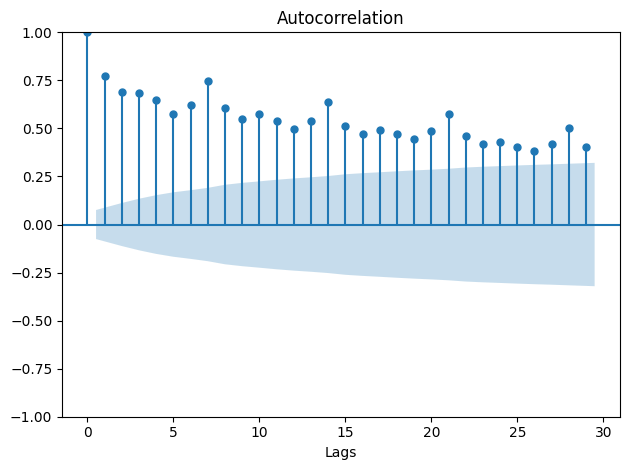

In [13]:
# Autocorrelation
alpha=0.05
# Select a multiple of the seasonal frequency for the number of lags
plot_acf(train_us)
plt.xlabel('Lags')
plt.tight_layout()

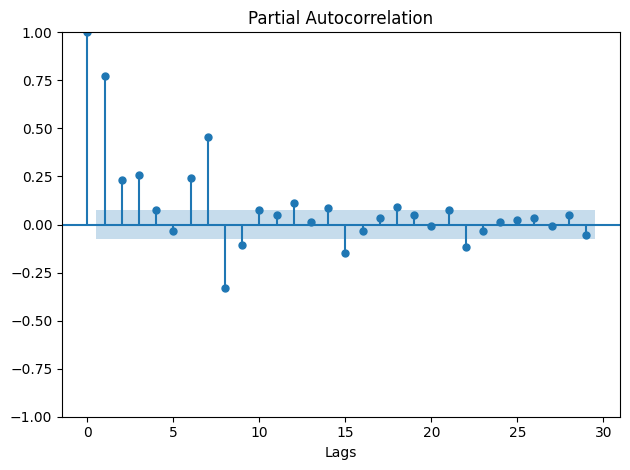

In [14]:
# Partial Autocorrelation
plot_pacf(train_us)
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

In [20]:
model_us = auto_arima(train_us, start_p=1, start_q=1,
                           max_p=7, max_q=7,
                           start_P=0, seasonal=True,
                           d=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(model_us.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16128.625, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16354.983, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16250.917, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16128.084, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16353.112, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16128.960, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16109.489, Time=0.78 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16111.039, Time=0.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16124.566, Time=0.59 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16133.967, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16117.630, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16004.265, Time=1.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16008.364, Time=2.31 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=16030.482, Time=0.99 sec
 ARIMA(1,1,4)(0,0,0

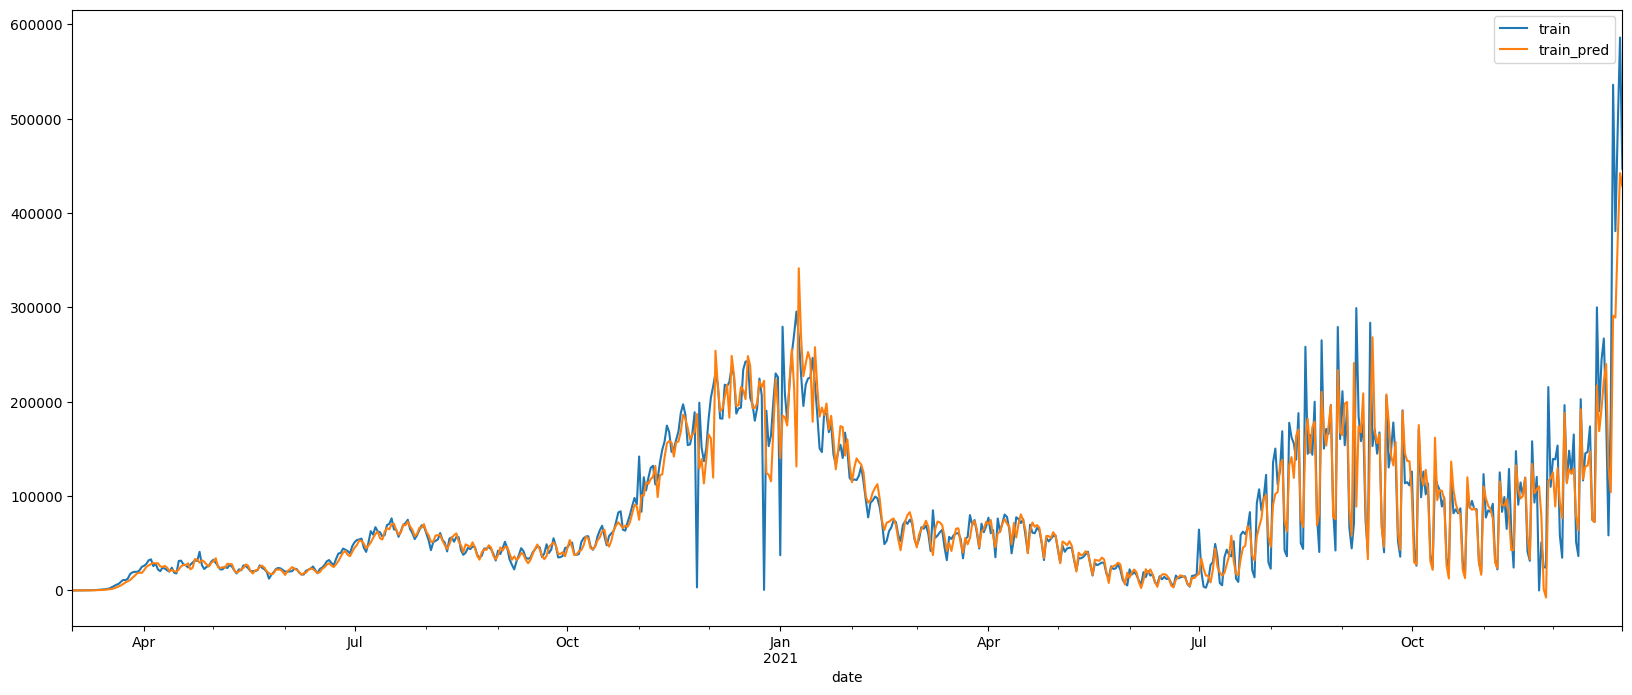

In [21]:
train_pred_us=model_us.fittedvalues()
pd.concat([train_us, train_pred_us], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])

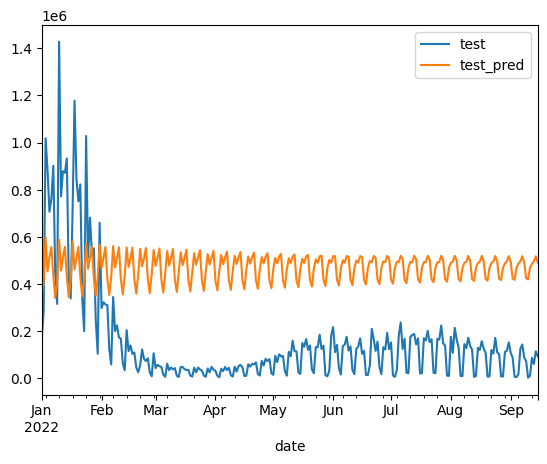

In [22]:
test_pred_us=model_us.predict(n_periods=len(test_us))
test_pred_us.index = test_us.index
pd.concat([test_us, test_pred_us], axis=1).plot()

plt.legend(['test', 'test_pred'])

In [32]:
model_performance(train_us, train_pred_us)

'RMSE: 34609.32573923586, MAPE: 489.1257213065555'

In [23]:
model_performance(test_us, test_pred_us)

'RMSE: 382118.4710336718, MAPE: 1159.0689763227874'

In [24]:
# use default
model_us_auto = auto_arima(train_us, seasonal=True, stepwise=True)

In [25]:
print(model_us_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  671
Model:               SARIMAX(2, 1, 5)   Log Likelihood               -7970.191
Date:                Sat, 09 Dec 2023   AIC                          15956.381
Time:                        02:09:26   BIC                          15992.440
Sample:                    03-01-2020   HQIC                         15970.348
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4590      0.013    -36.588      0.000      -0.484      -0.434
ar.L2         -0.9717      0.010    -92.665      0.000      -0.992      -0.951
ma.L1         -0.1056      0.024     -4.369      0.0

In [26]:
print(model_us_auto.order)

(2, 1, 5)


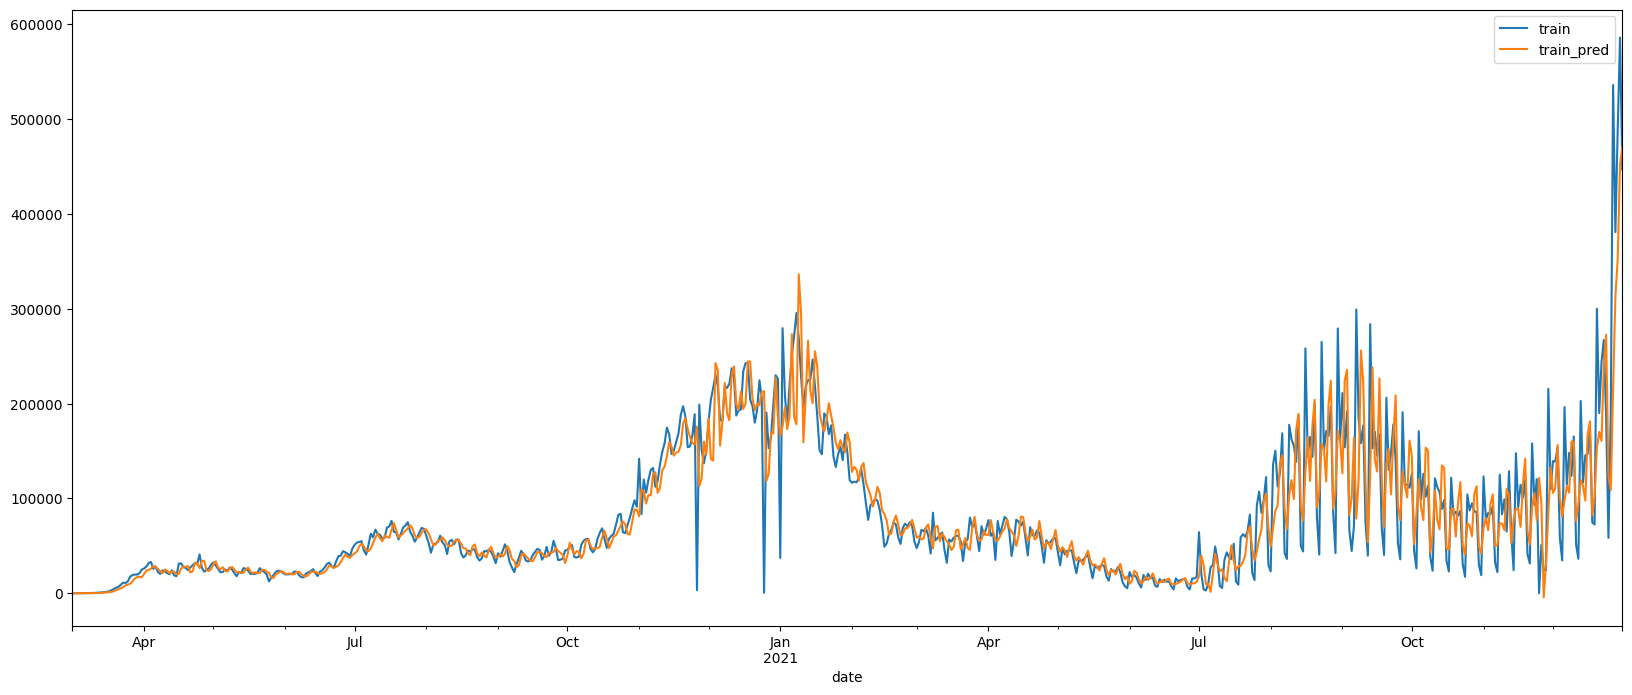

In [30]:
train_pred_us_auto=model_us_auto.fittedvalues()
pd.concat([train_us, train_pred_us_auto], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])

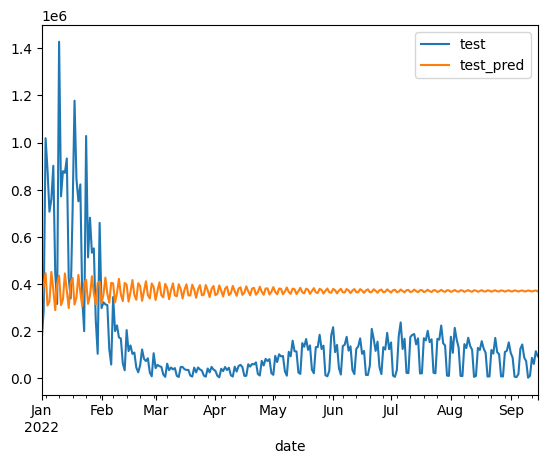

In [31]:
test_pred_us_auto=model_us_auto.predict(n_periods=len(test_us))
test_pred_us_auto.index = test_us.index
pd.concat([test_us, test_pred_us_auto], axis=1).plot()

plt.legend(['test', 'test_pred'])

In [34]:
model_performance(train_us, train_pred_us_auto)

'RMSE: 34609.32573923586, MAPE: 489.1257213065555'

In [33]:
model_performance(test_us, test_pred_us_auto)

'RMSE: 308472.82225478214, MAPE: 954.1599517923448'

In [38]:
# Auto tune a model for each country
train_pred = train_country_agg.copy()
train_pred.new_confirmed = None
train_pred.columns = ['country_code','prediected_new_confirmed']
train_pred.reset_index(inplace = True)
test_pred = test_country_agg.copy()
test_pred.new_confirmed = None
test_pred.columns = ['country_code','prediected_new_confirmed']
test_pred.reset_index(inplace = True)

In [39]:
train_pred

,date,country_code,prediected_new_confirmed
0,2020-03-01,AU,None
1,2020-03-02,AU,None
2,2020-03-03,AU,None
3,2020-03-04,AU,None
4,2020-03-05,AU,None
...,...,...,...
6600,2021-12-27,US,None
6601,2021-12-28,US,None
6602,2021-12-29,US,None
6603,2021-12-30,US,None


In [41]:
loc_list = list(train_country_agg.country_code.unique())
for loc in loc_list:
  train_interest = train_country_agg.loc[train_country_agg.country_code == loc, 'new_confirmed']
  test_interest = test_country_agg.loc[test_country_agg.country_code == loc, 'new_confirmed']
  # code the model
  model = auto_arima(train_interest, seasonal=True, stepwise=True)
  # predict train data
  pred_for_train = model.fittedvalues()
  for date in pred_for_train.index:
    train_pred.loc[(train_pred.country_code == loc) & (train_pred.date == date), 'prediected_new_confirmed'] = pred_for_train[date]
  # predict test dataset
  pred_for_test = model.predict(n_periods=len(test_interest))
  pred_for_test.index = test_interest.index
  for date in pred_for_test.index:
    test_pred.loc[(test_pred.country_code == loc) & (test_pred.date == date), 'prediected_new_confirmed'] = pred_for_test[date]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

In [42]:
train_pred

,date,country_code,prediected_new_confirmed
0,2020-03-01,AU,0.435007
1,2020-03-02,AU,0.65333
2,2020-03-03,AU,0.446933
3,2020-03-04,AU,0.767142
4,2020-03-05,AU,3.067337
...,...,...,...
6600,2021-12-27,US,216006.860655
6601,2021-12-28,US,312953.680404
6602,2021-12-29,US,352493.876472
6603,2021-12-30,US,452331.33224


In [43]:
# training data
model_performance(train_country_agg.new_confirmed, train_pred.prediected_new_confirmed)

<ipython-input-4-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
<ipython-input-4-41e2a7920411>:3: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'RMSE: 11039.52804537418, MAPE: nan'

In [46]:
# testing data
model_performance(test_country_agg.new_confirmed, test_pred.prediected_new_confirmed)

<ipython-input-4-41e2a7920411>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'RMSE: 135464.73115464766, MAPE: inf'